In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

## Background noise

In [3]:
from pathlib import Path
from birdclef import birdnet
from birdclef.utils import get_spark
from pyspark.sql import functions as F
import pickle
import tqdm
import time
import tensorflow as tf
from functools import partial
import librosa
from birdclef.data.utils import slice_seconds
import numpy as np

repo_path = Path("../data/models/birdnet-analyzer-pruned")
birdnet_model = birdnet.load_model_from_repo(repo_path)
embedding_func = birdnet.embedding_func(birdnet_model)


model_path = Path("../data/models/baseline/logistic_binary.pkl")
clf = pickle.loads(model_path.read_bytes())

# re-encode the classes properly for the inference script on logistic model
le_path = Path("../data/models/baseline/logistic_binary_label_encoder.pkl")
le = pickle.loads(le_path.read_bytes())
clf.classes_ = le.classes_

spark = get_spark()
spark

2023-05-22 01:39:52.766399: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-22 01:39:52.903422: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-22 01:39:53.634767: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-22 01:39:53.634871: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

23/05/22 01:40:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [14]:
def average_windows(prob):
    """Average a matrix of probabilities.

    We assume that these are a sliding window of probabilities: 1s sliding window of 3s context
    """
    # max might be better than the mean
    return prob.reshape(-1, 2, prob[0].size).max(axis=1)


def run_inference(path, embedding_func, clf, sr=48000):
    y, sr = librosa.load(path.as_posix(), sr=sr, mono=True)
    X = slice_seconds(y, sr, seconds=3, step=3)
    # drop every 4th/5th index, so we're not processing more than we need to
    # first pad the resulting slices by 2
    # X = np.pad(X, ((0, 2), (0, 0)))
    # # then reshape it
    # X = X.reshape(-1, 5, X.shape[-1])
    # # now drop the last 2 second of each 5 second frame
    # X = X[:, [0, 2], :].reshape(-1, X.shape[-1])
    # assert X.shape == (120 * 2, sr * 3), X.shape

    emb = embedding_func(X)[0]
    prob = clf.predict_proba(emb)
    # prob_prime = average_windows(prob)
    # assert prob_prime.shape == (120, len(clf.classes_)), prob_prime.shape
    rows = []
    for i, (probs_row, embs_row) in enumerate(zip(prob, emb)):
        ts = i * 3
        row = dict(
            row_id=f"{path.stem}_{ts}",
            emb=embs_row,
            **dict(zip(clf.classes_, np.around(probs_row, 6).tolist())),
        )
        rows.append(row)
    return rows


test_path = Path("../data/raw/background_audio/")
rows = []
timings = []
for path in tqdm.tqdm(test_path.glob("*.wav")):
    start = time.time()
    rows += run_inference(path, embedding_func, clf)
    timings.append(time.time() - start)

avg_time_sec = np.mean(timings)
est_time_min = avg_time_sec * 200 / 60
print(
    f"took {round(avg_time_sec,2)} seconds per loop, estimated {round(est_time_min,2)} minutes"
)

2034it [07:55,  4.28it/s]

took 0.23 seconds per loop, estimated 0.78 minutes


In [16]:
import pandas as pd

rows_df = pd.DataFrame(rows)
display(rows_df)

,row_id,emb,call,no_call
0,0c983624-94c9-488f-a30a-ff4607d91844_0,"[1.1818924, 0.69687766, 1.1667963, 1.0317755, ...",0.538661,0.461339
1,0c983624-94c9-488f-a30a-ff4607d91844_3,"[1.1214457, 0.76188916, 0.7962125, 0.6765547, ...",0.388857,0.611143
2,0c983624-94c9-488f-a30a-ff4607d91844_6,"[1.2807306, 0.84491163, 0.8637437, 0.88486797,...",0.584300,0.415700
3,0c983624-94c9-488f-a30a-ff4607d91844_9,"[1.2563839, 0.479892, 0.6529903, 1.1251913, 0....",0.651146,0.348854
4,324c7e9e-5962-49e2-ae32-c695a024ac26_0,"[0.9624719, 0.67970115, 0.7333389, 0.63427776,...",0.107948,0.892052
...,...,...,...,...
8131,2aad176a-4d4e-44d2-a878-2196db6286ea_9,"[0.7330778, 0.589925, 0.41016567, 0.8734188, 0...",0.055792,0.944208
8132,2a8691c8-c0eb-43c0-a278-b89fd208ac89_0,"[0.787512, 0.27573034, 1.3166825, 0.7790899, 0...",0.111515,0.888485
8133,2a8691c8-c0eb-43c0-a278-b89fd208ac89_3,"[0.8198209, 0.6048265, 1.4028617, 0.6779361, 0...",0.162488,0.837512
8134,2a8691c8-c0eb-43c0-a278-b89fd208ac89_6,"[0.83209085, 0.59048015, 1.4423491, 0.5654101,...",0.128994,0.871006


In [42]:
# Write out res to a parquet file, using 1 or 2 partitions.
# Use the processed/birdnet-2023 folder and make a new dataset under there.
spark_df = spark.createDataFrame(rows_df)
spark_df.repartition(2).write.mode("overwrite").parquet(
    "../data/processed/birdclef-2023/background_noise"
)

/home/mgustine/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]


23/05/22 02:22:50 WARN TaskSetManager: Stage 0 contains a task of very large size (2670 KiB). The maximum recommended task size is 1000 KiB.


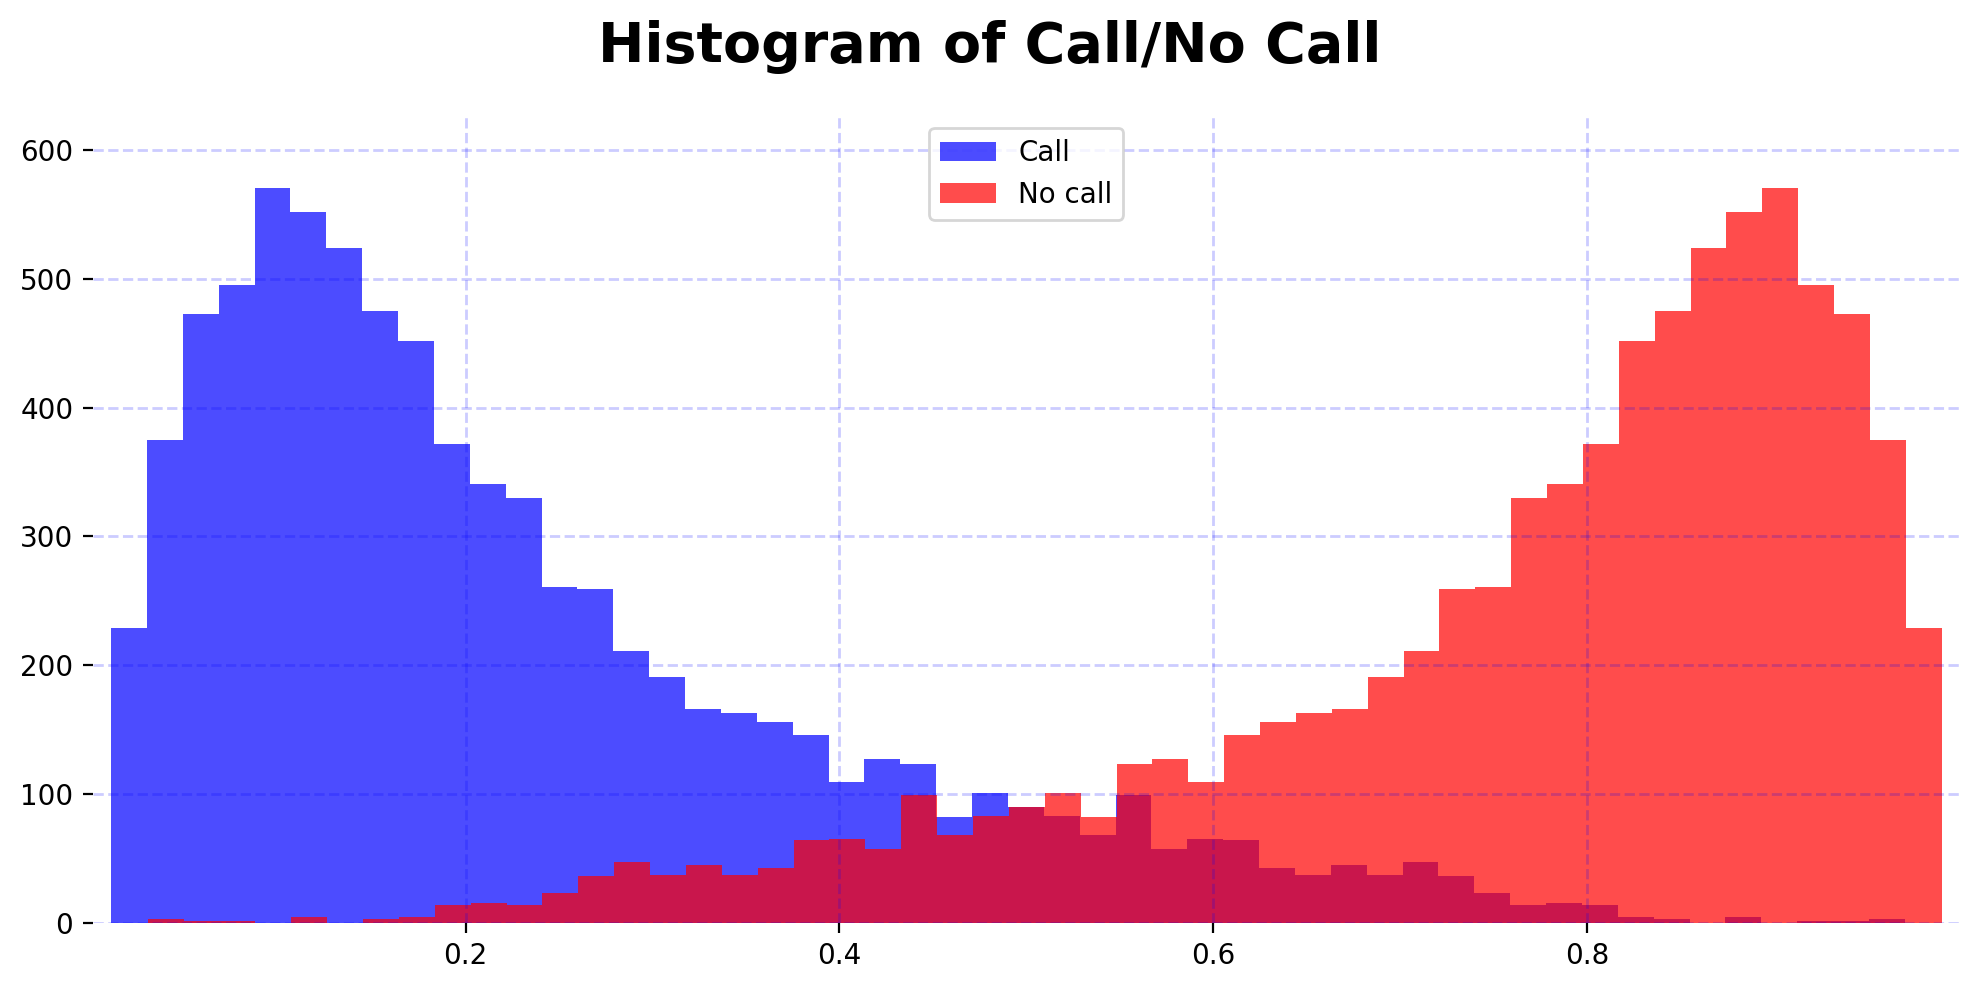

In [29]:
import matplotlib.pyplot as plt

# Get column names
cols = ["call", "no_call"]

# Init plot
fig, ax = plt.subplots(figsize=(10, 5), dpi=200)
ax.hist(rows_df["call"], bins=50, color="blue", label="Call", alpha=0.7, density=False)
ax.hist(
    rows_df["no_call"], bins=50, color="red", label="No call", alpha=0.7, density=False
)
plt.suptitle("Histogram of Call/No Call", size=20, weight="bold")
ax.margins(x=0.01, y=0.1)  # No margins on x and y-axis
ax.grid(color="blue", linestyle="--", linewidth=1, alpha=0.2)
for spine in ["top", "right", "bottom", "left"]:
    ax.spines[spine].set_visible(False)
fig.tight_layout()
ax.legend(loc="best")
fig.tight_layout()
plt.show()

In [23]:
call_sum = np.sum(rows_df["call"])
ncall_sum = np.sum(rows_df["no_call"])

print(f"Call sum: {round(call_sum, 3)}")
print(f"No call sum: {round(ncall_sum, 3)}")

Call sum: 1886.059
No call sum: 6249.941


In [24]:
total = call_sum + ncall_sum
nocall_perc = ncall_sum / total

print(round(nocall_perc, 3))

0.768


In [25]:
rows_df.describe()

,call,no_call
count,8136.000000,8136.000000
mean,0.231817,0.768183
std,0.173410,0.173410
min,0.010221,0.029923
25%,0.102268,0.683725
50%,0.179843,0.820157
75%,0.316275,0.897732
max,0.970077,0.989779


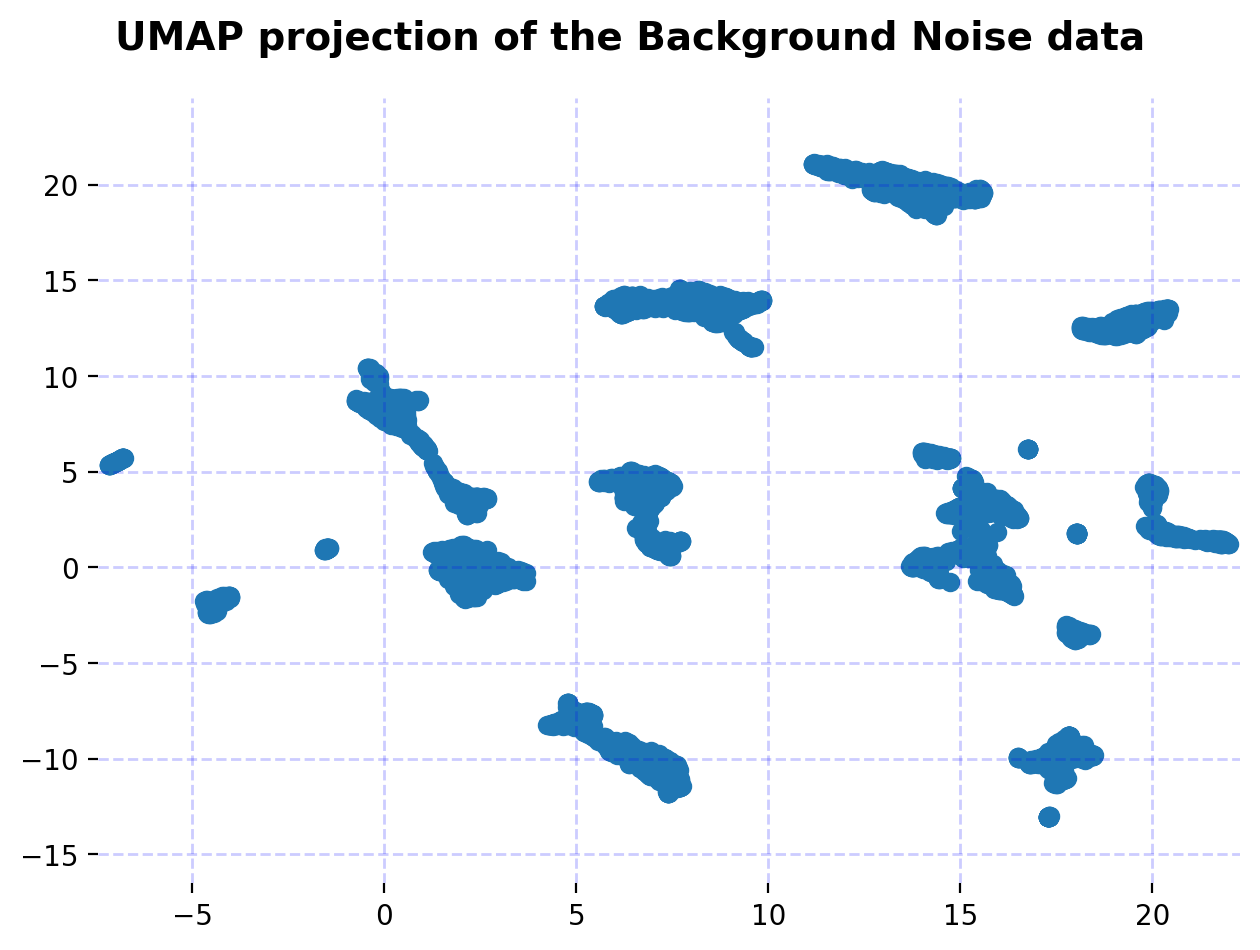

In [40]:
import umap
from sklearn.preprocessing import StandardScaler

# The "emb" column contains 320 samples for each row
data = np.stack(rows_df["emb"].values)
scaled_data = StandardScaler().fit_transform(data)

# Fit the UMAP model and transform the data
reducer = umap.UMAP()
embedding = reducer.fit_transform(data)

# Plot the data
fig, ax = plt.subplots(figsize=(6.4, 4.8), dpi=200)
plt.scatter(embedding[:, 0], embedding[:, 1])
plt.suptitle("UMAP projection of the Background Noise data", fontsize=14, weight="bold")
ax.margins(x=0.01, y=0.1)  # No margins on x and y-axis
ax.grid(color="blue", linestyle="--", linewidth=1, alpha=0.2)
for spine in ["top", "right", "bottom", "left"]:
    ax.spines[spine].set_visible(False)
fig.tight_layout()
# ax.legend(loc="best")
fig.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


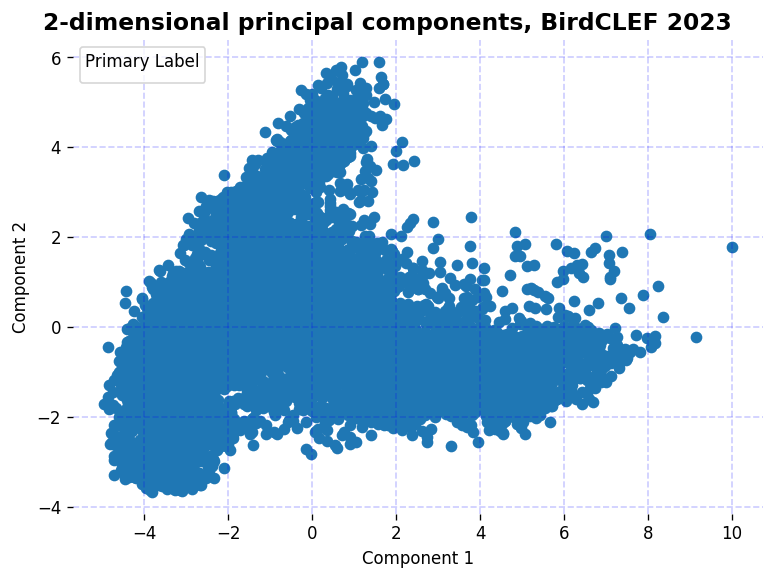

In [34]:
from sklearn.decomposition import PCA

X = np.stack(rows_df["emb"].values)
# primary_label = df.primary_label
# birdnet_label = df.birdnet_label

# PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)
pca_var = pca.explained_variance_ratio_
pca_curve = np.cumsum(pca_var)

# Create a new DataFrame with the PCA data and primary_label
pca_df = pd.DataFrame(X_pca, columns=["x", "y"])
# pca_df["primary_label"] = primary_label


# Plot 2-D PCA
def plot_pca_scatter(
    X_pca: np.array,
    # y_train: np.array,
    dataset_name="dataset",
    verbose=False,
):
    # Init figure
    fig, ax = plt.subplots(figsize=(6.4, 4.8), dpi=120)
    fig.suptitle(
        f"2-dimensional principal components, {dataset_name}",
        fontsize=14,
        weight="bold",
    )
    # primary_label = pca_df["primary_label"]
    # sns.scatterplot(data=pca_df, x="x", y="y", hue="primary_label")
    ax.scatter(pca_df["x"], pca_df["y"])
    ax.margins(x=0.05, y=0.05)  # margins on x and y axis
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.grid(color="blue", linestyle="--", linewidth=1, alpha=0.2)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles=handles,
        labels=labels,
        title="Primary Label",
        loc="upper left",
        fontsize="small",
    )
    spines = ["top", "right", "bottom", "left"]
    for s in spines:
        ax.spines[s].set_visible(False)
    fig.tight_layout(pad=0.5)
    plt.show()


# Plot the BirdNET embeddings
plot_pca_scatter(
    X_pca=pca_df,
    dataset_name="BirdCLEF 2023",
)